In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input\competitive-data-science-predict-future-sales\items.csv
../input\competitive-data-science-predict-future-sales\item_categories.csv
../input\competitive-data-science-predict-future-sales\sales_train.csv
../input\competitive-data-science-predict-future-sales\sample_submission.csv
../input\competitive-data-science-predict-future-sales\shops.csv
../input\competitive-data-science-predict-future-sales\test.csv


In [24]:
pd.set_option('display.max_columns', None)

import pprint as pp
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as skl
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, Lasso, LinearRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import lightgbm as lgb

from xgboost import XGBClassifier, XGBRegressor

from scipy import stats
from scipy.special import boxcox1p

%matplotlib inline

In [25]:
trainCsvFilepath = r'../input\competitive-data-science-predict-future-sales\sales_train.csv'
rawTrainDf = pd.read_csv(trainCsvFilepath)

testCsvFilepath = r'../input\competitive-data-science-predict-future-sales\test.csv'
rawTestDf = pd.read_csv(testCsvFilepath)

shopsCsvFilepath = r'../input\competitive-data-science-predict-future-sales\shops.csv'
shopsDf = pd.read_csv(shopsCsvFilepath)

itemsCsvFilepath = r'../input\competitive-data-science-predict-future-sales\items.csv'
itemsDf = pd.read_csv(itemsCsvFilepath)

In [26]:
print(rawTrainDf.shape)
print(rawTestDf.shape)
print(shopsDf.shape)
print(itemsDf.shape)

(2935849, 6)
(214200, 3)
(60, 2)
(22170, 3)


In [27]:
display(rawTrainDf.head())
display(rawTestDf.head())
display(shopsDf.head())
display(itemsDf.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [29]:
print(rawTestDf.isna().sum().sum())
print(rawTrainDf.isna().sum().sum())


0
0


# Join tables

In [37]:
joinedTrainDf = rawTrainDf.join(itemsDf, on=['item_id'], rsuffix='r', ).join(shopsDf, on=['shop_id'], rsuffix='r').drop(columns=['item_idr', 'shop_idr'])
display(joinedTrainDf.head())
print(joinedTrainDf.isna().sum().sum())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум"""


0


In [47]:
display(joinedTrainDf.describe())

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


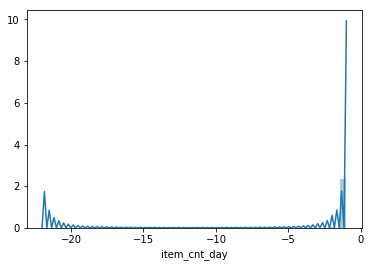

In [55]:
sns.distplot(joinedTrainDf[joinedTrainDf.item_cnt_day < 0].item_cnt_day)

In [56]:
joinedTrainDf[joinedTrainDf.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name
484683,15.05.2013,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19,"Москва ТЦ ""Серебряный Дом"""


## Check if item price changes for same item_id

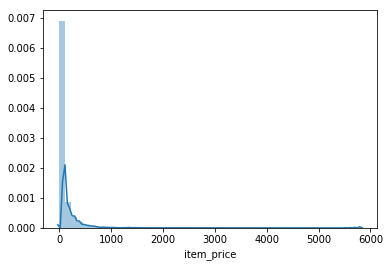

In [54]:
pricesGroupBy_item_id = joinedTrainDf.groupby(by=['item_id']).item_price.std().dropna()
sns.distplot(pricesGroupBy_item_id)